In [ ]:
#@title Importing used packages
import torch
import torchvision
import pickle

import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output 

!pip install torchinfo
clear_output()

from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

Generative models aim to generate datapoints from the distribution of a given dataset.

Generative Adversarial Nets (**GANs**) are such models which have been proposed by Ian Goodfellow in 2014. They rely on a generator/discriminator architecture where the discriminator tries to distinguish between real images coming from our dataset and fake generated images, and the generator tries to generate images as close as the ones in our dataset.

As these models involve trying to replicate a distribution, in the sense that they try make it so that the distribution of the images produced by the generator are as close as possible to the real distribution ; there have been different papers which tried to make use of optimal transport to enhance these models.

In the paper [Improving GANs Using Optimal Transport](https://arxiv.org/abs/1803.05573), Tim Salimans \& al introduce a new optimal transport inspired objective function to train **GANs**.

In [ ]:
#@title Optimal Transport enhanced GAN
class OT_GAN(nn.Module):
  '''Class to Implement Optimal Transport enhance GAN'''

  def __init__(self, device, input_img_channels = 1, gen_feature_channels = [8,64,32], hidden_embed = 64, input_size = 100, output_size = 32, cost_embedding_size = 16, nb_steps_sinkhorn = 50, entropy_regularization = 500):
    
    super().__init__()
    

    self.device = device
    self.gen_feature_channels = gen_feature_channels
    self.output_size = output_size
    
    #Sinkhorn divergence parameters
    self.nb_steps = nb_steps_sinkhorn
    self.alpha = entropy_regularization
    
    #Generator layers
    self.gfc=nn.Linear(input_size, (output_size+6)*(output_size+6)*gen_feature_channels[0])
    self.gconv1 = nn.Conv2d(gen_feature_channels[0], gen_feature_channels[1],3)
    self.gconv2 = nn.Conv2d(gen_feature_channels[1], gen_feature_channels[2], 3)
    self.gconv3 = nn.Conv2d(gen_feature_channels[2], input_img_channels, 3)

    
    #Learned cost function layers
    self.fc1 = nn.Linear(output_size*output_size, hidden_embed )
    self.fc2 = nn.Linear(hidden_embed,cost_embedding_size)
    self.cos_sim = torch.nn.CosineSimilarity(0)

    #Activation related functions
    self.gbnorm1 = nn.BatchNorm1d((output_size+6)*(output_size+6)*gen_feature_channels[0])
    self.gbnorm2 = nn.BatchNorm2d(gen_feature_channels[1])
    self.gbnorm3 = nn.BatchNorm2d(gen_feature_channels[2])

    self.relu = nn.ReLU()
    self.gelu = nn.GELU()

  #######################################
  #return optimizers
  #######################################
  def init_optimizers(self):
    '''Define optimizer (outside of __init__ in case we import weights)'''
    self.generator_optimizer = torch.optim.Adam([{"params" : self.gfc.parameters()},
                                                 {"params" : self.gconv1.parameters()},
                                                 {"params" : self.gconv2.parameters()},
                                                 {"params" : self.gconv3.parameters()}])
    
    self.discrim_optimizer = torch.optim.Adam([{"params" : self.fc1.parameters()},
                                               {"params" : self.fc2.parameters()}])
    
    return(self.generator_optimizer,self.discrim_optimizer)


  #######################################
  #Pairwise cosine distance after embedding
  #######################################
  def embed_for_cost(self,x):
    '''Function to embed a batch of images and normalize result to compute cost function
    x : batch of images'''
    embed_x = torch.flatten(x,start_dim = 1)
    embed_x = self.fc1(embed_x)
    embed_x = self.gelu(embed_x)
    embed_x = self.fc2(embed_x)

    normalized_embed_x = torch.nn.functional.normalize(embed_x)
    return(normalized_embed_x)
  
  
  def pw_cosine_distance(self, normalized_embedded_batch_x, normalized_embedded_batch_y):
   '''Given a batch of (normalized) vectors, compute the pairwise cosine distance between the vectors of the first batch and of the second batch
   embedded_batch_x : batch of 1d vectors
   embedded_batch_y : second batch of 1d vectors with which to compute pairwise cosine distance'''
   result = torch.mm(normalized_embedded_batch_x, normalized_embedded_batch_y.T)
   result *= -1 
   result += 1
   return result

  #######################################
  #Sinkhorn
  #######################################

  def sinkhorn(self,cost_matrix):
    '''Implement Sinkhorn's divergence algorithm for soft matching
    cost_matrix : cost matrix (between two batches)'''
    cloned_cost_matrix = cost_matrix.clone().detach()
    K = torch.exp(-cloned_cost_matrix/self.alpha)
    n = cost_matrix.shape[0]
    u = (torch.ones(n)/n).to(device)
    
    normalized_one_vector = (torch.ones(n)/n).to(device)

    v = normalized_one_vector / torch.matmul(K.T,u)

    for i in range(self.nb_steps) :
      u = normalized_one_vector / torch.matmul(K,v)
      v = normalized_one_vector / torch.matmul(K.T,u)
    
    transport_plan = torch.matmul(torch.matmul(torch.diag(u), K), torch.diag(v))

    return transport_plan
  

  #######################################
  #Compute OT distance between batches
  #######################################


  def loss_fct(self, x0, x1, y0, y1, discrim = False):
    '''Compute loss function between batches
    x0 and x1 : 2 batches of real images
    y. and y1 : 2 batches of generated images
    '''
    #First step, is to get normalized embedding of each of the batch images
    embed_x0 = self.embed_for_cost(x0)
    embed_x1 = self.embed_for_cost(x1)
    embed_y0 = self.embed_for_cost(y0)
    embed_y1 = self.embed_for_cost(y1)

    #Now, get pairwise cosine distance between the batches of interest
    cost_matrix_1 = self.pw_cosine_distance(embed_x0,embed_y0)
    cost_matrix_2 = self.pw_cosine_distance(embed_x0,embed_y1)
    cost_matrix_3 = self.pw_cosine_distance(embed_x1,embed_y0)
    cost_matrix_4 = self.pw_cosine_distance(embed_x1,embed_y1)
    cost_matrix_5 = self.pw_cosine_distance(embed_x0,embed_x1)
    cost_matrix_6 = self.pw_cosine_distance(embed_y0,embed_y1)
    
    #Get OT plan and compute distance for each pair of batches
    ot_plan_1 = self.sinkhorn(cost_matrix_1)
    dist_1 = torch.trace(torch.matmul(ot_plan_1, cost_matrix_1.T))

    ot_plan_2 = self.sinkhorn(cost_matrix_2)
    dist_2 = torch.trace(torch.matmul(ot_plan_2, cost_matrix_2.T))

    ot_plan_3 = self.sinkhorn(cost_matrix_3)
    dist_3 = torch.trace(torch.matmul(ot_plan_3, cost_matrix_3.T))

    ot_plan_4 = self.sinkhorn(cost_matrix_4)
    dist_4 = torch.trace(torch.matmul(ot_plan_4, cost_matrix_4.T))

    ot_plan_5 = self.sinkhorn(cost_matrix_5)
    dist_5 = torch.trace(torch.matmul(ot_plan_5, cost_matrix_5.T))

    ot_plan_6 = self.sinkhorn(cost_matrix_6)
    dist_6 = torch.trace(torch.matmul(ot_plan_6, cost_matrix_2.T))



    loss = dist_1 + dist_2 + dist_3 + dist_4 -2*dist_5 -2*dist_6

    if discrim :
      loss = -1*loss
    return loss

  #######################################
  #generator 
  #######################################
  def forward(self,x):
    '''Apply generator to noise  vector
    x : noise vector'''



    h1 = self.gfc(x)
    h1 = self.gelu(h1)
    h1 = h1.view(-1,self.gen_feature_channels[0], self.output_size+6, self.output_size+6)

    
    h2 = self.gconv1(h1)
    h2 = self.gelu(h2)

    h3 = self.gconv2(h2)
    h3 = self.relu(h3)

    h4 = self.gconv3(h3)
    h4 = self.gelu(h4)

    return(h4)


In [ ]:
#@title Download MNIST dataset
!mkdir "/content/mnist_data"
mnist_dataset = MNIST("/content/mnist_data", train = True, download = True, transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()]))
mnist_dataloader = DataLoader(mnist_dataset, batch_size = 64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to /content/mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/mnist_data/MNIST/raw



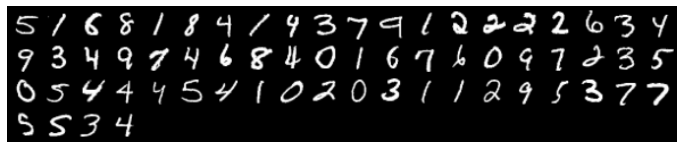

In [ ]:
#@title Plot a few examples taken from the dataset
sample = next(iter(mnist_dataloader))[:20]
imgs,labels = sample
plt.figure(figsize=(12,12))
plt.axis("off")
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs)
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

In [ ]:
#@title Function to train the model
def train_model(model, n_epochs, verbose, dataloader, device, save_path, n_discrim =3 , batch_size = 32 , label =True, input_size = 100, new_ckpt = 20):
  '''train OT-GAN model
  model : OT-GAN model
  n_epochs : number of epochs for which to train model
  verbose : if set to True, print loss after each epoch
  dataloader : training dataloader
  device : cpu or gpu
  save_path : path used to save checkpoints weights
  n_discrim : after how many generator training steps to train the discriminator
  batch_size : batch size of each batch used to train the model (size of each of the 4 batches)
  label : set to True if dataloader returns a tensor and labels (to only keep img labels)
  nb_channels : number of channels of the image used for training
  '''
  
  model = model.to(device)
  losses_list = []#Store average epoch losses
  for i in tqdm(range(n_epochs)):
    avg_loss = 0#avg epoch loss
    count_ = 0#Number of images treated (to get average loss)
    for current,x in enumerate(dataloader):
      if label :#Only keep images
        x = x[0]
      if x.shape[0]!= 2*batch_size:#There have been issues without this line 
        break
      else :
        x = x.to(device)
        
        first_real_batch = (x[:batch_size]).to(device)#first batch of real images
        second_real_batch = (x[batch_size:2*batch_size]).to(device)#Second batch of real images
        input_noise = torch.randn((2*batch_size, input_size )).to(device)#Noise from which to generate images
        output_imgs = model(input_noise)

        first_gen_batch = (output_imgs[:batch_size])#first batch of generated images
        second_gen_batch = (output_imgs[batch_size:])#second batch of generated images

        first_gen_batch = first_gen_batch.to(device)
        second_gen_batch = second_gen_batch.to(device)
        
        if current % n_discrim == 1:#check if we train discriminator
          discrim = True
          optimizer = model.init_optimizers()[1]#discriminator optimizer
        else:
          discrim = False
          optimizer = model.init_optimizers()[0]#generator optimizer
        optimizer.zero_grad()#zero gradient
        loss = model.loss_fct(first_gen_batch, second_gen_batch, first_real_batch, second_real_batch, discrim)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        count_ += batch_size
    if verbose :
      print("Average epoch loss is", round(avg_loss/count_,5))
    temp_save_path = save_path + str(i//new_ckpt) +".pth"
    torch.save(model.state_dict(), temp_save_path)
    losses_list.append(avg_loss/count_)
  return losses_list


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = "/content/drive/MyDrive/optimal_transport_gan/ckpt_mod4"

In [ ]:
#@title Train model
model = OT_GAN(device)
losses = train_model(model, 100, True, mnist_dataloader, device, save_path)

with open("/content/drive/MyDrive/optimal_transport_gan/mod4_losses.pickles","wb") as f:
  pickle.dump(losses,f)

  1%|          | 1/100 [01:09<1:55:23, 69.94s/it]

Average epoch loss is 0.00767


  2%|▏         | 2/100 [02:18<1:52:42, 69.00s/it]

Average epoch loss is 0.00598


  3%|▎         | 3/100 [03:26<1:50:57, 68.63s/it]

Average epoch loss is 0.00908


  4%|▍         | 4/100 [04:34<1:49:20, 68.34s/it]

Average epoch loss is 0.00953


  5%|▌         | 5/100 [05:42<1:47:51, 68.13s/it]

Average epoch loss is 0.00854


  6%|▌         | 6/100 [06:49<1:46:05, 67.72s/it]

Average epoch loss is 0.00883


  7%|▋         | 7/100 [07:55<1:44:27, 67.39s/it]

Average epoch loss is 0.00957


  8%|▊         | 8/100 [09:02<1:42:59, 67.17s/it]

Average epoch loss is 0.00877


  9%|▉         | 9/100 [10:09<1:41:46, 67.11s/it]

Average epoch loss is 0.00924


 10%|█         | 10/100 [11:16<1:40:31, 67.02s/it]

Average epoch loss is 0.00919


 11%|█         | 11/100 [12:23<1:39:29, 67.08s/it]

Average epoch loss is 0.00861


 12%|█▏        | 12/100 [13:30<1:38:22, 67.07s/it]

Average epoch loss is 0.00864


 13%|█▎        | 13/100 [14:37<1:37:16, 67.08s/it]

Average epoch loss is 0.00866


 14%|█▍        | 14/100 [15:44<1:36:02, 67.01s/it]

Average epoch loss is 0.00792


 15%|█▌        | 15/100 [16:51<1:34:46, 66.90s/it]

Average epoch loss is 0.00832


 16%|█▌        | 16/100 [17:57<1:33:32, 66.82s/it]

Average epoch loss is 0.00829


 17%|█▋        | 17/100 [19:04<1:32:19, 66.75s/it]

Average epoch loss is 0.00784


 18%|█▊        | 18/100 [20:10<1:30:54, 66.52s/it]

Average epoch loss is 0.00719


 19%|█▉        | 19/100 [21:16<1:29:35, 66.36s/it]

Average epoch loss is 0.00746


 20%|██        | 20/100 [22:22<1:28:31, 66.39s/it]

Average epoch loss is 0.00754


 21%|██        | 21/100 [23:28<1:27:18, 66.31s/it]

Average epoch loss is 0.00673


 22%|██▏       | 22/100 [24:35<1:26:07, 66.25s/it]

Average epoch loss is 0.00665


 23%|██▎       | 23/100 [25:40<1:24:51, 66.12s/it]

Average epoch loss is 0.00701


 24%|██▍       | 24/100 [26:46<1:23:35, 66.00s/it]

Average epoch loss is 0.00671


 25%|██▌       | 25/100 [27:52<1:22:18, 65.85s/it]

Average epoch loss is 0.00753


 26%|██▌       | 26/100 [28:57<1:21:13, 65.85s/it]

Average epoch loss is 0.007


 27%|██▋       | 27/100 [30:03<1:20:12, 65.92s/it]

Average epoch loss is 0.00629


 28%|██▊       | 28/100 [31:10<1:19:15, 66.05s/it]

Average epoch loss is 0.00608


 29%|██▉       | 29/100 [32:16<1:18:22, 66.23s/it]

Average epoch loss is 0.00584


 30%|███       | 30/100 [33:23<1:17:16, 66.23s/it]

Average epoch loss is 0.00641


 31%|███       | 31/100 [34:28<1:15:54, 66.00s/it]

Average epoch loss is 0.00641


 32%|███▏      | 32/100 [35:34<1:14:52, 66.07s/it]

Average epoch loss is 0.00597


 33%|███▎      | 33/100 [36:40<1:13:47, 66.08s/it]

Average epoch loss is 0.00619


 34%|███▍      | 34/100 [37:46<1:12:35, 65.99s/it]

Average epoch loss is 0.00602


 35%|███▌      | 35/100 [38:52<1:11:22, 65.89s/it]

Average epoch loss is 0.00605


 36%|███▌      | 36/100 [39:58<1:10:21, 65.97s/it]

Average epoch loss is 0.0059


 37%|███▋      | 37/100 [41:04<1:09:16, 65.98s/it]

Average epoch loss is 0.0063


 38%|███▊      | 38/100 [42:10<1:08:10, 65.98s/it]

Average epoch loss is 0.00566


 39%|███▉      | 39/100 [43:16<1:07:08, 66.05s/it]

Average epoch loss is 0.00556


 40%|████      | 40/100 [44:23<1:06:07, 66.13s/it]

Average epoch loss is 0.00516


 41%|████      | 41/100 [45:29<1:05:00, 66.11s/it]

Average epoch loss is 0.0053


 42%|████▏     | 42/100 [46:35<1:03:54, 66.12s/it]

Average epoch loss is 0.00574


 43%|████▎     | 43/100 [47:41<1:02:44, 66.04s/it]

Average epoch loss is 0.00627


 44%|████▍     | 44/100 [48:47<1:01:36, 66.01s/it]

Average epoch loss is 0.00557


 45%|████▌     | 45/100 [49:53<1:00:34, 66.09s/it]

Average epoch loss is 0.00571


 46%|████▌     | 46/100 [50:59<59:25, 66.03s/it]  

Average epoch loss is 0.00484


 47%|████▋     | 47/100 [52:05<58:22, 66.08s/it]

Average epoch loss is 0.00558


 48%|████▊     | 48/100 [53:11<57:18, 66.13s/it]

Average epoch loss is 0.00508


 49%|████▉     | 49/100 [54:17<56:10, 66.09s/it]

Average epoch loss is 0.00519


 50%|█████     | 50/100 [55:23<55:00, 66.00s/it]

Average epoch loss is 0.00568


 51%|█████     | 51/100 [56:29<53:51, 65.96s/it]

Average epoch loss is 0.005


 52%|█████▏    | 52/100 [57:35<52:43, 65.90s/it]

Average epoch loss is 0.00507


 53%|█████▎    | 53/100 [58:41<51:38, 65.93s/it]

Average epoch loss is 0.00414


 54%|█████▍    | 54/100 [59:46<50:30, 65.89s/it]

Average epoch loss is 0.00435


 55%|█████▌    | 55/100 [1:00:53<49:31, 66.04s/it]

Average epoch loss is 0.00446


 56%|█████▌    | 56/100 [1:01:59<48:28, 66.11s/it]

Average epoch loss is 0.00466


 57%|█████▋    | 57/100 [1:03:05<47:22, 66.12s/it]

Average epoch loss is 0.00404


 58%|█████▊    | 58/100 [1:04:11<46:13, 66.04s/it]

Average epoch loss is 0.00528


 59%|█████▉    | 59/100 [1:05:17<45:05, 65.98s/it]

Average epoch loss is 0.00505


 60%|██████    | 60/100 [1:06:23<44:00, 66.01s/it]

Average epoch loss is 0.00503


 61%|██████    | 61/100 [1:07:29<42:55, 66.03s/it]

Average epoch loss is 0.0053


 62%|██████▏   | 62/100 [1:08:35<41:47, 65.99s/it]

Average epoch loss is 0.00466


 63%|██████▎   | 63/100 [1:09:41<40:42, 66.01s/it]

Average epoch loss is 0.00535


 64%|██████▍   | 64/100 [1:10:47<39:31, 65.88s/it]

Average epoch loss is 0.00463


 65%|██████▌   | 65/100 [1:11:52<38:23, 65.82s/it]

Average epoch loss is 0.00475


 66%|██████▌   | 66/100 [1:12:58<37:17, 65.80s/it]

Average epoch loss is 0.00444


 67%|██████▋   | 67/100 [1:14:04<36:15, 65.93s/it]

Average epoch loss is 0.00415


 68%|██████▊   | 68/100 [1:15:11<35:14, 66.07s/it]

Average epoch loss is 0.00515


 69%|██████▉   | 69/100 [1:16:17<34:09, 66.11s/it]

Average epoch loss is 0.00522


 70%|███████   | 70/100 [1:17:23<33:03, 66.12s/it]

Average epoch loss is 0.005


 71%|███████   | 71/100 [1:18:29<31:58, 66.16s/it]

Average epoch loss is 0.00472


 72%|███████▏  | 72/100 [1:19:36<30:53, 66.18s/it]

Average epoch loss is 0.00527


 73%|███████▎  | 73/100 [1:20:42<29:47, 66.20s/it]

Average epoch loss is 0.00422


 74%|███████▍  | 74/100 [1:21:48<28:38, 66.08s/it]

Average epoch loss is 0.00446


 75%|███████▌  | 75/100 [1:22:54<27:32, 66.12s/it]

Average epoch loss is 0.00467


 76%|███████▌  | 76/100 [1:24:00<26:25, 66.07s/it]

Average epoch loss is 0.00466


 77%|███████▋  | 77/100 [1:25:06<25:18, 66.03s/it]

Average epoch loss is 0.00489


 78%|███████▊  | 78/100 [1:26:11<24:10, 65.93s/it]

Average epoch loss is 0.00487


 79%|███████▉  | 79/100 [1:27:17<23:05, 65.99s/it]

Average epoch loss is 0.00501


 80%|████████  | 80/100 [1:28:24<22:00, 66.04s/it]

Average epoch loss is 0.00448


 81%|████████  | 81/100 [1:29:29<20:53, 65.96s/it]

Average epoch loss is 0.00533


 82%|████████▏ | 82/100 [1:30:35<19:46, 65.92s/it]

Average epoch loss is 0.00588


 83%|████████▎ | 83/100 [1:31:41<18:39, 65.82s/it]

Average epoch loss is 0.00507


 84%|████████▍ | 84/100 [1:32:47<17:33, 65.82s/it]

Average epoch loss is 0.00501


 85%|████████▌ | 85/100 [1:33:53<16:27, 65.86s/it]

Average epoch loss is 0.00507


 86%|████████▌ | 86/100 [1:34:58<15:19, 65.70s/it]

Average epoch loss is 0.00508


 87%|████████▋ | 87/100 [1:36:03<14:12, 65.56s/it]

Average epoch loss is 0.00525


 88%|████████▊ | 88/100 [1:37:08<13:05, 65.48s/it]

Average epoch loss is 0.0044


 89%|████████▉ | 89/100 [1:38:14<12:00, 65.50s/it]

Average epoch loss is 0.00527


 90%|█████████ | 90/100 [1:39:20<10:56, 65.69s/it]

Average epoch loss is 0.0052


 91%|█████████ | 91/100 [1:40:26<09:51, 65.77s/it]

Average epoch loss is 0.00483


 92%|█████████▏| 92/100 [1:41:32<08:46, 65.77s/it]

Average epoch loss is 0.00482


 93%|█████████▎| 93/100 [1:42:38<07:40, 65.78s/it]

Average epoch loss is 0.00567


 94%|█████████▍| 94/100 [1:43:44<06:35, 65.85s/it]

Average epoch loss is 0.00457


 95%|█████████▌| 95/100 [1:44:49<05:28, 65.78s/it]

Average epoch loss is 0.00559


 96%|█████████▌| 96/100 [1:45:55<04:23, 65.82s/it]

Average epoch loss is 0.00485


 97%|█████████▋| 97/100 [1:47:01<03:17, 65.93s/it]

Average epoch loss is 0.00515


 98%|█████████▊| 98/100 [1:48:09<02:12, 66.45s/it]

Average epoch loss is 0.00622


 99%|█████████▉| 99/100 [1:49:15<01:06, 66.28s/it]

Average epoch loss is 0.00597


100%|██████████| 100/100 [1:50:21<00:00, 66.22s/it]

Average epoch loss is 0.00594


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


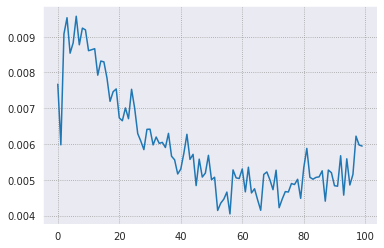

In [ ]:
#@title Evolution of training error
sns.lineplot(range(100),losses)
plt.show()

In [ ]:
ot_model = OT_GAN(device)
ot_model.load_state_dict(torch.load("/content/drive/MyDrive/optimal_transport_gan/ckpt_mod41.pth",map_location=torch.device(device)))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


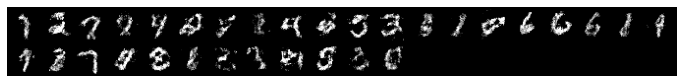

In [ ]:
#@title Image generation
imgs = ot_model(torch.randn((32,100)))
plt.figure(figsize=(12,12))
plt.axis("off")
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs)
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');